In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
Merged_data = pd.read_excel('Merged_data.xlsx')
Merged_data.set_index('Date', inplace=True)
Merged_data.dtypes

temperature_2m (°C)                float64
relative_humidity_2m (%)             int64
precipitation (mm)                 float64
et0_fao_evapotranspiration (mm)    float64
wind_speed_10m (km/h)              float64
wind_gusts_10m (km/h)              float64
soil_temperature_0_to_7cm (°C)     float64
soil_moisture_0_to_7cm (m³/m³)     float64
direct_radiation (W/m²)              int64
Turbidity                          float64
dtype: object

In [3]:
Merged_data

,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),et0_fao_evapotranspiration (mm),wind_speed_10m (km/h),wind_gusts_10m (km/h),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),direct_radiation (W/m²),Turbidity
Date,,,,,,,,,,
2020-12-31 15:00:00,4.0,78,0.0,0.05,9.8,20.5,4.4,0.391,55,0.430411
2020-12-31 16:00:00,3.4,85,0.0,0.02,5.6,18.4,4.1,0.391,25,0.522836
2020-12-31 17:00:00,1.5,94,0.0,0.01,7.3,9.7,3.5,0.390,3,0.512069
2020-12-31 18:00:00,0.8,95,0.0,0.00,7.1,9.4,2.9,0.389,0,0.450545
2020-12-31 19:00:00,-0.1,97,0.0,0.00,8.4,10.4,2.3,0.388,0,0.405494
...,...,...,...,...,...,...,...,...,...,...
2023-12-30 05:00:00,6.9,90,0.0,0.01,21.5,37.4,7.3,0.399,0,0.455236
2023-12-30 06:00:00,6.9,90,0.0,0.01,21.4,36.7,7.1,0.399,0,0.398240
2023-12-30 07:00:00,6.7,91,0.0,0.00,19.0,36.4,7.0,0.398,0,0.413984


In [4]:
Merged_data['Turbidity'].isnull().sum()

0

In [5]:
# Create lag features
# lags = [1, 3, 6, 12, 24]
# for col in ['Turbidity']:
    # for lag in lags:
        # Merged_data[f'{col}_lag_{lag}'] = Merged_data[col].shift(lag)

# Create rolling features
# rolling_windows = [1*24, 2*24, 3*24]
# for col in ['Turbidity']:
    # for window in rolling_windows:
        # Merged_data[f'{col}_rolling_mean_{window}'] = Merged_data[col].rolling(window=window).mean()

# Replace NaN values with the mean of the column
# Merged_data.fillna(Merged_data.mean(), inplace=True)




In [6]:
Merged_data.shape

(26251, 10)

In [7]:
X = Merged_data.drop(columns=['Turbidity'])
y = Merged_data['Turbidity']
train_size = int(len(Merged_data) * 0.7)
val_size = int(len(Merged_data) * 0.1)
test_size = len(Merged_data) - train_size - val_size
train_data = Merged_data[:train_size]
val_data = Merged_data[train_size:train_size + val_size]
test_data = Merged_data[train_size + val_size:]


In [8]:
X_train = train_data.drop(columns=['Turbidity'])
y_train = train_data['Turbidity']
X_val = val_data.drop(columns=['Turbidity'])
y_val = val_data['Turbidity']
X_test = test_data.drop(columns=['Turbidity'])
y_test = test_data['Turbidity']

In [11]:
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
}

# Initialize variables to keep track of the best model
best_mae = float('inf')
best_rmse = float('inf')
best_r2 = -float('inf')
best_mape = float('inf')
best_model = None
best_params = (0, 0, 0)

for n in param_grid['n_estimators']:
    for lr in param_grid['learning_rate']:
        for depth in param_grid['max_depth']:
            print(f"Training with n_estimators={n}, learning_rate={lr}, max_depth={depth}")
            model = XGBRegressor(n_estimators=n, learning_rate=lr, max_depth=depth, random_state=42)
            model.fit(X_train, y_train)

            # Validate the model
            val_predictions = model.predict(X_val)
            val_mae = mean_absolute_error(y_val, val_predictions)
            val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
            val_r2 = r2_score(y_val, val_predictions)
            val_mape = mean_absolute_percentage_error(y_val, val_predictions)
            if val_mae < best_mae:
                best_mae = val_mae
                best_rmse = val_rmse
                best_r2 = val_r2
                best_mape = val_mape
                best_model = model
                best_params = (n, lr, depth)   

                
print(f"Best parameters: n_estimators={best_params[0]}, learning_rate={best_params[1]}, max_depth={best_params[2]}") 




Training with n_estimators=100, learning_rate=0.01, max_depth=3
Training with n_estimators=100, learning_rate=0.01, max_depth=5
Training with n_estimators=100, learning_rate=0.01, max_depth=7
Training with n_estimators=100, learning_rate=0.01, max_depth=9
Training with n_estimators=100, learning_rate=0.05, max_depth=3
Training with n_estimators=100, learning_rate=0.05, max_depth=5
Training with n_estimators=100, learning_rate=0.05, max_depth=7
Training with n_estimators=100, learning_rate=0.05, max_depth=9
Training with n_estimators=100, learning_rate=0.1, max_depth=3
Training with n_estimators=100, learning_rate=0.1, max_depth=5
Training with n_estimators=100, learning_rate=0.1, max_depth=7
Training with n_estimators=100, learning_rate=0.1, max_depth=9
Training with n_estimators=100, learning_rate=0.2, max_depth=3
Training with n_estimators=100, learning_rate=0.2, max_depth=5
Training with n_estimators=100, learning_rate=0.2, max_depth=7
Training with n_estimators=100, learning_rate=0

Validation MAE: 0.10730568715708148
Validation RMSE: 0.38539117209779994
Validation R2: 0.772627225078323
Validation MAPE: 0.14350801001117744


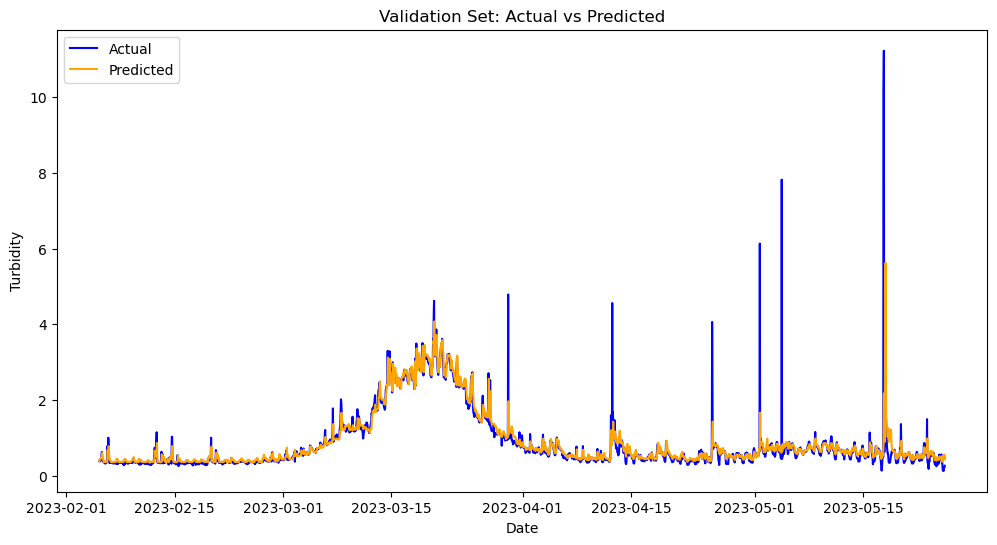

In [12]:
# Test the best model using the best parameters
best_model = XGBRegressor(n_estimators=best_params[0], learning_rate=best_params[1], max_depth=best_params[2], random_state=42)
best_model.fit(X_train, y_train)
# Validate the model on the validation set
val_predictions = best_model.predict(X_val)
val_mae = mean_absolute_error(y_val, val_predictions)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
val_r2 = r2_score(y_val, val_predictions)
val_mape = mean_absolute_percentage_error(y_val, val_predictions)
print(f"Validation MAE: {val_mae}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation R2: {val_r2}")
print(f"Validation MAPE: {val_mape}")
# Plotting the predictions vs actual values for validation set
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val, label='Actual', color='blue')
plt.plot(y_val.index, val_predictions, label='Predicted', color='orange')
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Turbidity')
plt.legend()
plt.show()




Test MAE: 0.2721552510808814
Test RMSE: 0.9694448036101705
Test R2: 0.8342586320369069
Test MAPE: 0.13340814622448882


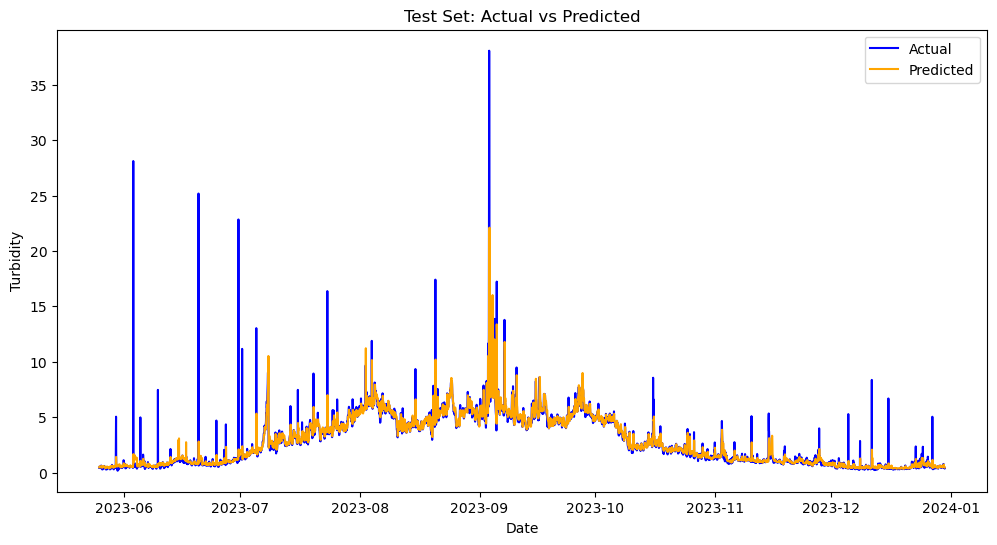

In [13]:
# Test the best model using the best parameters on the test set
best_model = XGBRegressor(n_estimators=best_params[0], learning_rate=best_params[1], max_depth=best_params[2], random_state=42)
best_model.fit(X_train, y_train)
# Test the model on the test set
test_predictions = best_model.predict(X_test)
# Calculate metrics
test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
print(f"Test MAE: {test_mae}")
print(f"Test RMSE: {test_rmse}")    
print(f"Test R2: {test_r2}")
print(f"Test MAPE: {test_mape}")
# Plotting the predictions vs actual values for test set
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, test_predictions, label='Predicted', color='orange')
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Turbidity')
plt.legend()
plt.show()



Train MAE: 0.16605661829460294
Train RMSE: 0.5436257183569775
Train R2: 0.9343201942576288
Train MAPE: 316596407076.49115


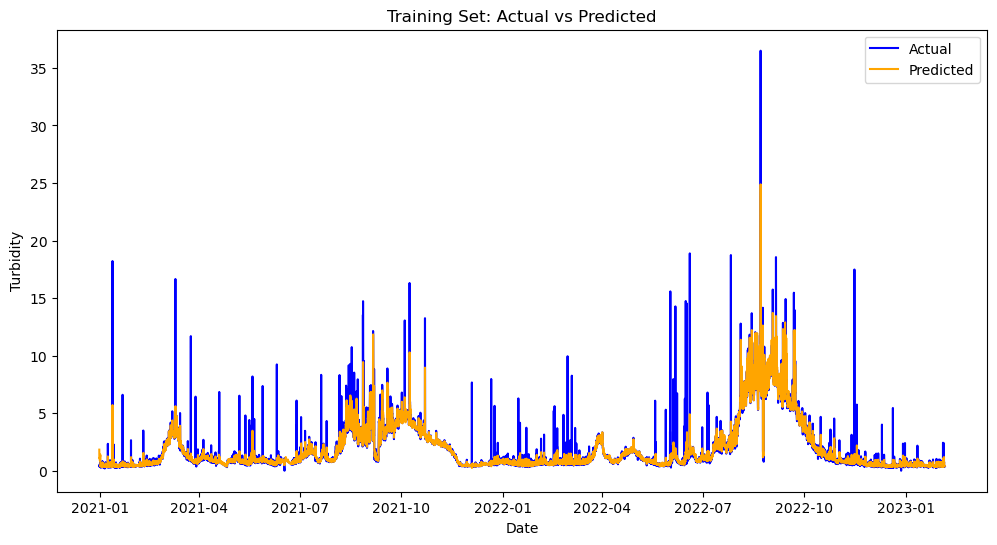

In [14]:
# Test the best model using the best parameters on the training set
best_model = XGBRegressor(n_estimators=best_params[0], learning_rate=best_params[1], max_depth=best_params[2], random_state=42)
best_model.fit(X_train, y_train)
# Test the model on the training set
train_predictions = best_model.predict(X_train)
# Calculate metrics
train_mae = mean_absolute_error(y_train, train_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_r2 = r2_score(y_train, train_predictions)
train_mape = mean_absolute_percentage_error(y_train, train_predictions)
print(f"Train MAE: {train_mae}")
print(f"Train RMSE: {train_rmse}")
print(f"Train R2: {train_r2}")
print(f"Train MAPE: {train_mape}")
# Plotting the predictions vs actual values for training set
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Actual', color='blue')
plt.plot(y_train.index, train_predictions, label='Predicted', color='orange')
plt.title('Training Set: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Turbidity')
plt.legend()
plt.show()


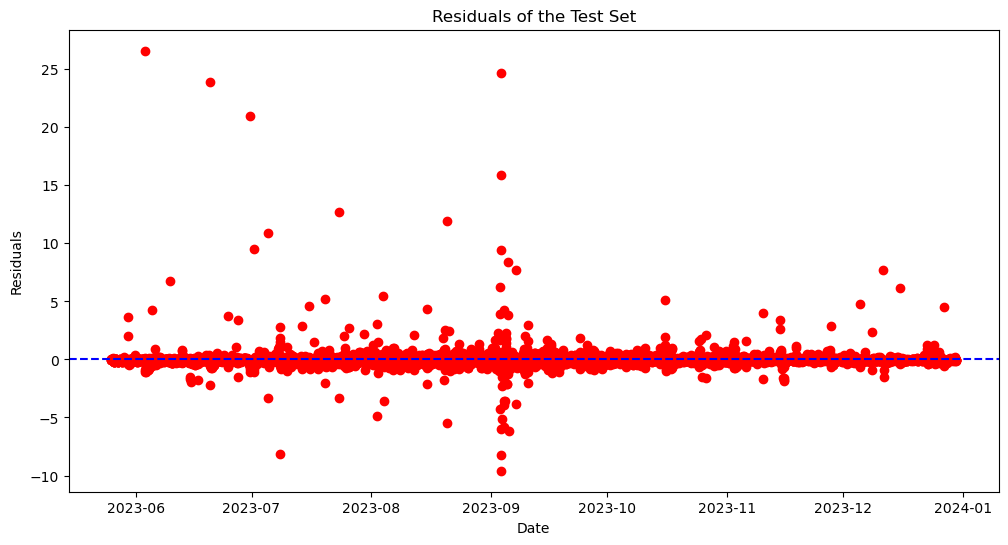

In [15]:
# Plotting the residuals for the test set
residuals = y_test - test_predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_test.index, residuals, color='red')
plt.axhline(0, color='blue', linestyle='--')
plt.title('Residuals of the Test Set')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()
